In [1]:
%load_ext autoreload
%autoreload 2
import eval_models
import pandas as pd
import numpy as np
from boruta import BorutaPy
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['font.size'] = 25


### Lets try out mcfs on artificial and its results
Note: the output is from R so we will have to transform it a little bit. The easiest is to open file in excel and delete ,class, at the end of each row

In [2]:
X_art_train,X_art_test,y_art_train,y_art_test=eval_models.get_train_test("artificial")

In [3]:
x_times_mcfs=5
mcfs_all_results=pd.read_csv('../data/mcfs/artificial-features.csv',header=None,sep="\n")
mcfs_all_results=mcfs_all_results.iloc[:,0].str.split(',', expand=True)
mcfs_all_array=np.array(list(filter(None,np.array(mcfs_all_results).flatten()))).astype(np.int64)

In [4]:
unique, counts=np.unique(mcfs_all_array,return_counts=True)
columns_mcfs= unique[counts>=x_times_mcfs*0.95]

In [5]:
#nie wiem czemu, ale iloc nie chciał działać
X_art_train_mcfs_multiple=X_art_train.loc[:,list(columns_mcfs)]
X_art_train_mcfs_multiple.head()

,64,105,128,241,281,318,336,338,433,442,451,472,475,493
508,588,484,478,425,487,443,602,573,509,613,469,533,377,636
242,468,554,484,534,563,530,451,343,625,377,488,415,529,546
1024,301,755,500,578,448,529,278,389,451,440,485,458,612,464
782,367,612,490,527,452,555,327,441,459,471,491,470,521,473
677,586,454,475,489,533,482,584,472,576,434,477,447,475,506


In [6]:
eval_models.get_models_ba(X_art_train_mcfs_multiple,
                              X_art_test,
                              y_art_train,
                              y_art_test,
                          n_estimators=250
                             )

LogisticRegression 0.632
RandomForestClassifier 0.846
AdaBoostClassifier 0.626
LGBMClassifier 0.86
XGBClassifier 0.85
14  features in the dataset


,Classifier,BA score
0,LogisticRegression,0.632
1,RandomForestClassifier,0.846
2,AdaBoostClassifier,0.626
3,LGBMClassifier,0.860
4,XGBClassifier,0.850


In [7]:
X_art_train_scaled,X_art_test_scaled=eval_models.standarize(X_art_train,X_art_test)
X_art_train_scaled_mcfs_multiple=X_art_train_scaled.loc[:,columns_mcfs]

In [8]:
res_mcfs_no_vif=eval_models.get_models_ba(X_art_train_scaled_mcfs_multiple,
                              X_art_test_scaled,
                              y_art_train,
                              y_art_test,
                          n_estimators=250
                             )
res_mcfs_no_vif['VIF']='No (14 features)'

LogisticRegression 0.626
RandomForestClassifier 0.846
AdaBoostClassifier 0.622
LGBMClassifier 0.864
XGBClassifier 0.85
14  features in the dataset


In [9]:
X_art_train_scaled_mcfs_multiple_vif=eval_models.delete_multicollinear(X_art_train_scaled_mcfs_multiple)

13
12
11
10
9
8
7
6
5
5 features left


In [10]:
res_mcfs_yes_vif=eval_models.get_models_ba(X_art_train_scaled_mcfs_multiple_vif,
                              X_art_test_scaled,
                              y_art_train,
                              y_art_test,
                          n_estimators=250)
res_mcfs_yes_vif['VIF']='Yes (5 features)'

LogisticRegression 0.636
RandomForestClassifier 0.84
AdaBoostClassifier 0.638
LGBMClassifier 0.834
XGBClassifier 0.826
5  features in the dataset


In [11]:
res_mcfs_all=pd.concat([res_mcfs_no_vif,res_mcfs_yes_vif])
res_mcfs_all

,Classifier,BA score,VIF
0,LogisticRegression,0.626,No (14 features)
1,RandomForestClassifier,0.846,No (14 features)
2,AdaBoostClassifier,0.622,No (14 features)
3,LGBMClassifier,0.864,No (14 features)
4,XGBClassifier,0.850,No (14 features)
0,LogisticRegression,0.636,Yes (5 features)
1,RandomForestClassifier,0.840,Yes (5 features)
2,AdaBoostClassifier,0.638,Yes (5 features)
3,LGBMClassifier,0.834,Yes (5 features)
4,XGBClassifier,0.826,Yes (5 features)


In [12]:
res_mcfs_all.replace(to_replace=['LogisticRegression','RandomForestClassifier','AdaBoostClassifier','LGBMClassifier','XGBClassifier'],value=['Logistic Regression','Random Forest','AdaBoost','LightGBM','XGBoost'],inplace=True)

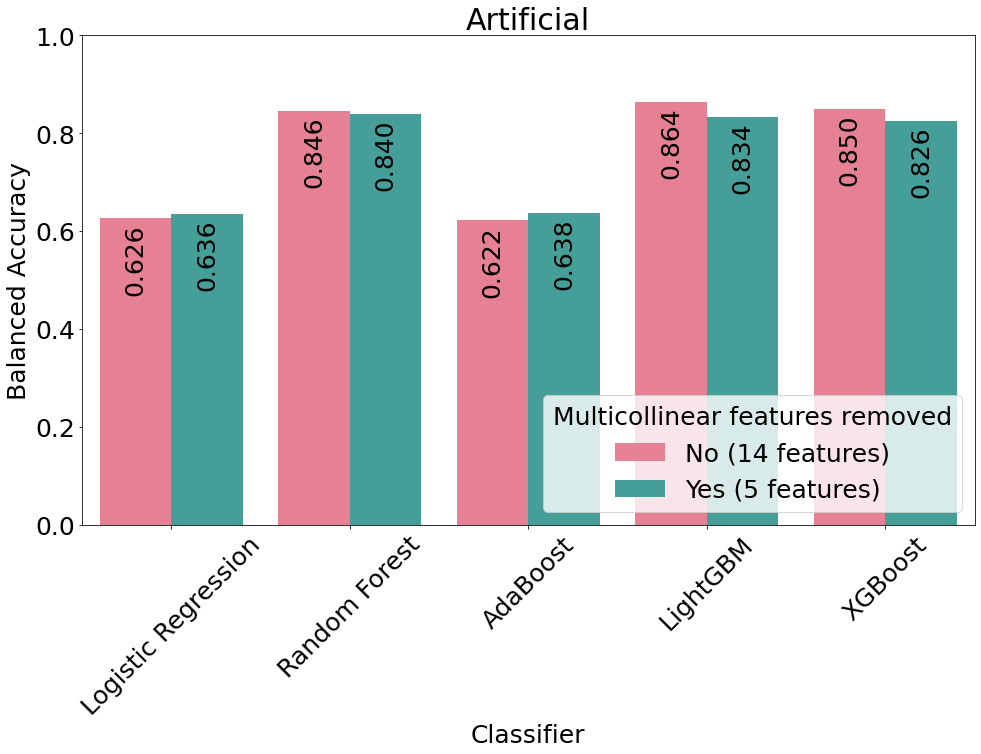

In [13]:
bars = sns.barplot(x='Classifier', y='BA score', hue='VIF', data=res_mcfs_all,palette=sns.color_palette("husl", 2))
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.3f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()-0.1), ha='center', va='center', xytext=(0, 8), rotation=90,
                   textcoords='offset points')
plt.ylim(0, 1)
plt.legend(loc=4, title='Multicollinear features removed')
plt.xlabel('Classifier')
plt.ylabel('Balanced Accuracy')
plt.title('Artificial')#\nClassifiers performance after Monte Carlo feature selection')
plt.xticks(rotation=45)
plt.show()